# Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Import Files

In [2]:
df = pd.read_csv("online_retail_II.csv")

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.shape

(1067371, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


# Data Cleaning

#### Missing Value

In [6]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [7]:
df.dropna(inplace = True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

#### Clean Data Type

In [8]:
df["Customer ID"] = df["Customer ID"].astype(int)

In [9]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

#### Remove Invalid Transactions

In [10]:
df = df[(df['Quantity'] > 0)]
df = df[(df['Price'] > 0)]

#### Create a new column "TotalPrice"

In [11]:
df["TotalPrice"] = df["Quantity"]*df["Price"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


# RFM Metrics

## Recency

In [12]:
print("Min Date", df["InvoiceDate"].min())
print("Max Date", df["InvoiceDate"].max())

Min Date 2009-12-01 07:45:00
Max Date 2011-12-09 12:50:00


In [14]:
recency = (dt.datetime(2012, 1, 1) - df.groupby("Customer ID").agg({"InvoiceDate":"max"})).rename(columns = {"InvoiceDate":"Recency"})


In [15]:
recency["Recency"] = recency["Recency"].apply(lambda x: x.days)
recency.head()

,Recency
Customer ID,
12346,347
12347,24
12348,97
12349,40
12350,332


## Frequency

In [17]:
frequency = df.groupby("Customer ID").agg({"InvoiceDate":"nunique"}).rename(columns={"InvoiceDate": "Frequency"})
frequency.head()

,Frequency
Customer ID,
12346,12
12347,8
12348,5
12349,4
12350,1


## Monetary 

In [18]:
monetary = df.groupby("Customer ID").agg({"TotalPrice":"sum"}).rename(columns={"TotalPrice":"Monetary"})
monetary.head()

,Monetary
Customer ID,
12346,77556.46
12347,5633.32
12348,2019.40
12349,4428.69
12350,334.40


## RFM Score

In [19]:
rfm = pd.concat([recency, frequency, monetary],  axis=1)
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,347,12,77556.46
12347,24,8,5633.32
12348,97,5,2019.40
12349,40,4,4428.69
12350,332,1,334.40


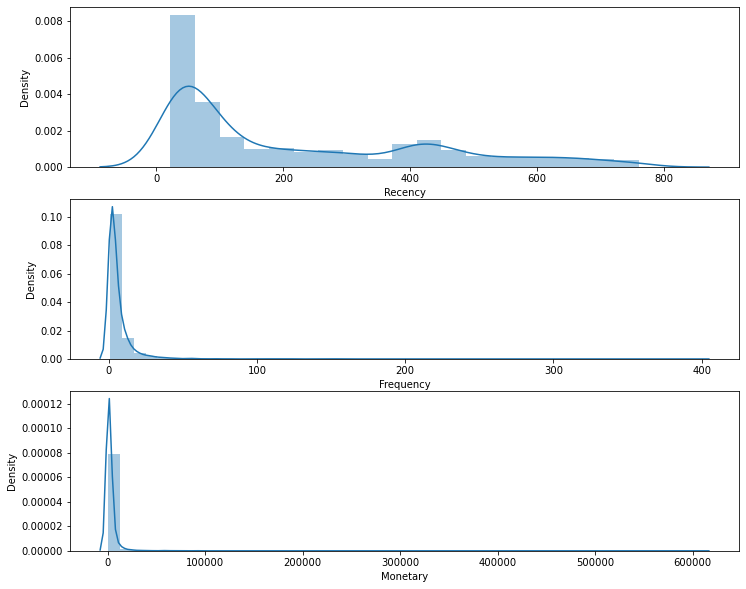

In [20]:
plt.figure(figsize=(12,10))

plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])
plt.subplot(3, 1, 3); sns.distplot(rfm['Monetary'])
plt.show()

# RFM Score Segmentation

Reference for group definition https://documentation.bloomreach.com/engagement/docs/rfm-segmentation

In [21]:
rfm["RecencyScore"]  = pd.qcut(rfm["Recency"], 5, labels = [5, 4 , 3, 2, 1])
rfm["FrequencyScore"]= pd.qcut(rfm["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
rfm["MonetaryScore"] = pd.qcut(rfm['Monetary'], 5, labels = [1, 2, 3, 4, 5])
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
Customer ID,,,,,,
12346,347,12,77556.46,2,5,5
12347,24,8,5633.32,5,4,5
12348,97,5,2019.40,3,4,4
12349,40,4,4428.69,5,3,5
12350,332,1,334.40,2,1,2


In [22]:
rfm["RFM_SCORE"] = (rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) + rfm['MonetaryScore'].astype(str))
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
Customer ID,,,,,,,
12346,347,12,77556.46,2,5,5,255
12347,24,8,5633.32,5,4,5,545
12348,97,5,2019.40,3,4,4,344
12349,40,4,4428.69,5,3,5,535
12350,332,1,334.40,2,1,2,212


In [23]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'}

In [24]:
rfm['Segment'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)

In [25]:
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
Customer ID,,,,,,,,
12346,347,12,77556.46,2,5,5,255,Can't Loose
12347,24,8,5633.32,5,4,5,545,Champions
12348,97,5,2019.40,3,4,4,344,Loyal Customers
12349,40,4,4428.69,5,3,5,535,Potential Loyalists
12350,332,1,334.40,2,1,2,212,Hibernating


# K-means Clustering

In [26]:
rfm_kmeans = rfm.loc[:,"Recency":"Monetary"]
rfm_kmeans.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,347,12,77556.46
12347,24,8,5633.32
12348,97,5,2019.40
12349,40,4,4428.69
12350,332,1,334.40


#### Normalize the data before K-means

In [27]:
sc = MinMaxScaler((0,1))
dataframe = sc.fit_transform(rfm_kmeans)

In [28]:
kmeans = KMeans(n_clusters = 10, init='k-means++')
k_fit = kmeans.fit(dataframe)
k_fit.labels_

array([7, 9, 5, ..., 3, 8, 9], dtype=int32)

Text(0.5, 1.0, 'Elbow method for optimal number of clusters')

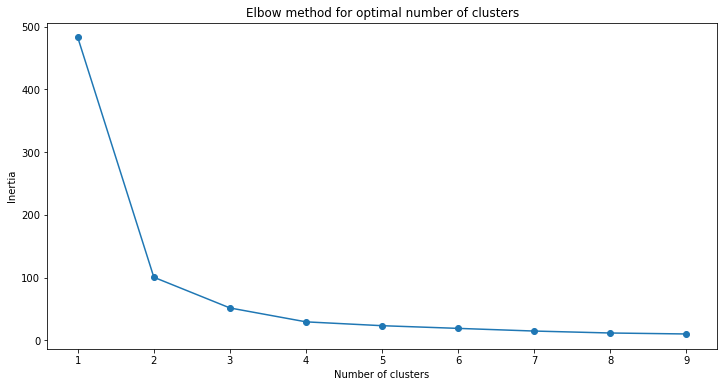

In [29]:
SSE = []
for cluster in list(range(1,10)):
    kmeans = KMeans( n_clusters = cluster, init='k-means++')
    kmeans.fit(dataframe)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':list(range(1,10)), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title("Elbow method for optimal number of clusters")

In [30]:
kmeans = KMeans(n_clusters = 3).fit(dataframe)
clusters = kmeans.labels_
pd.DataFrame({"Customer ID": rfm.index, "Cluster": clusters})
rfm_kmeans["cluster"] = clusters
rfm_kmeans["cluster"] = rfm_kmeans["cluster"] + 1
rfm_kmeans.head()

,Recency,Frequency,Monetary,cluster
Customer ID,,,,
12346,347,12,77556.46,2
12347,24,8,5633.32,1
12348,97,5,2019.40,1
12349,40,4,4428.69,1
12350,332,1,334.40,2


# Clustering Result

In [31]:
result=rfm_kmeans.reset_index()
result.head()

,Customer ID,Recency,Frequency,Monetary,cluster
0,12346,347,12,77556.46,2
1,12347,24,8,5633.32,1
2,12348,97,5,2019.40,1
3,12349,40,4,4428.69,1
4,12350,332,1,334.40,2


In [32]:
# number of customers in each group
result.groupby('cluster')["Customer ID"].count().sort_values(ascending=False)

cluster
1    3598
2    1505
3     775
Name: Customer ID, dtype: int64

<AxesSubplot:ylabel='cluster'>

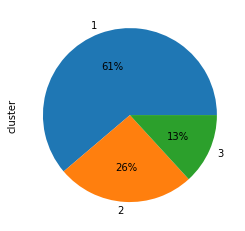

In [33]:
result.groupby('cluster')["cluster"].count().plot(kind='pie', y='points', autopct='%1.0f%%')

In [34]:
# see the characterictic in each clustering group
pd.set_option('display.max_columns', None)
round(result.groupby('cluster')[['Recency','Frequency','Monetary']].mean(),2)

,Recency,Frequency,Monetary
cluster,,,
1,75.14,8.66,4316.15
2,370.94,2.90,1131.42
3,621.16,1.72,659.51
